In [70]:
import ast
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
proteome = pd.read_excel("processed_data/uniprot/30aa_nounchar_noputative_ref_proteome_protein_existence_filtered_02.xlsx", header=0)
proteome = set(proteome['Entry'].unique())

In [36]:
huri = pd.read_excel('processed_data/interactomes/huri/huri_final.xlsx')
string = pd.read_excel('processed_data/interactomes/string/string_high_conf_final.xlsx')
hippie = pd.read_excel('processed_data/interactomes/hippie/hippie_binary_hq_final.xlsx')
bioplex = pd.read_excel('processed_data/interactomes/bioplex/bioplex_293t_final.xlsx')
apid = pd.read_excel('processed_data/interactomes/apid/apid_final.xlsx')
pickle = pd.read_excel('processed_data/interactomes/pickle/pickle_final.xlsx')
biogrid = pd.read_csv('processed_data/interactomes/biogrid/biogrid_final.tsv', sep='\t')
iid = pd.read_csv('processed_data/interactomes/iid/iid_exp_final.tsv', sep='\t')

In [59]:
huri_prots = set(huri['protein1_uniprot'].to_list() + huri['protein2_uniprot'].to_list())
string_prots = set(string['protein1_uniprot'].to_list() + string['protein2_uniprot'].to_list())
hippie_prots = set(hippie['protein1_uniprot'].to_list() + hippie['protein2_uniprot'].to_list())
bioplex_prots = set(bioplex['protein1_uniprot'].to_list() + bioplex['protein2_uniprot'].to_list())
apid_prots = set(apid['UniprotID_A'].to_list() + apid['UniprotID_B'].to_list())
pickle_prots = set(pickle['InteractorA'].to_list() + pickle['InteractorB'].to_list())
biogrid_prots = set(biogrid['SWISS-PROT Accessions Interactor A'].to_list() + biogrid['SWISS-PROT Accessions Interactor B'].to_list())
iid_prots = set(iid['uniprot1'].to_list() + iid['uniprot2'].to_list())

## Disease-related genes

In [ ]:
# from https://ftp.ncbi.nlm.nih.gov/pub/clinvar/
# each variant at a location on the genome for which data have been submitted to ClinVar
# data for the variant are reported for each assembly, we are taking GRCh38
# clinical significance is pathogenic

clinvar = pd.read_table('raw_data/extras/variant_summary.txt')
clinvar = clinvar[clinvar['Assembly'] == 'GRCh38'] 
disease_genes = clinvar[clinvar['ClinicalSignificance'] == 'Pathogenic'] 
# disease_genes['HGNC_ID'].drop_duplicates().to_csv('raw_data/extras/clinvar_genes.txt', sep=' ', index=False, header=None)
# after id mapping using UniProt ID mapping tool
disease_genes = pd.read_csv('raw_data/extras/mapped_disease_genes.tsv', sep='\t')
disease_genes = proteome.intersection(set(disease_genes['Entry'].unique()))

## Cancer genes

In [42]:
# cancer genes from COSMIC v97
cgc = pd.read_csv('raw_data/extras/cancer_gene_census.csv')
cgc = cgc[cgc['Tier'] == 1]
cgc['Entrez GeneId'] = cgc['Entrez GeneId'].astype(np.int64)
#cgc['Entrez GeneId'].to_csv('raw_data/extras/cgc_genes.txt', sep=' ', index=False, header=None)
# after id mapping using UniProt ID mapping tool
cancer_genes = pd.read_csv('raw_data/extras/mapped_cgc_genes.tsv', sep='\t')
cancer_genes = proteome.intersection(set(cancer_genes['Entry'].unique()))

## Drug targets

In [43]:
# drug targets from https://www.guidetopharmacology.org/DATA/targets_and_families.csv
drug_targets = pd.read_csv('raw_data/extras/targets_and_families.csv', skiprows=1)
drug_targets = proteome.intersection(set(drug_targets['Human SwissProt'].unique()))

# Analysis

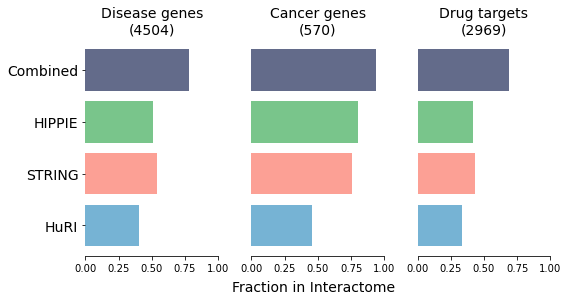

In [117]:
databases = [huri_prots, string_prots, hippie_prots]
combined = set().union(*databases)

interactomes = [huri_prots, string_prots, hippie_prots, combined]
inames = ['HuRI', 'STRING', 'HIPPIE', 'Combined']

data = [disease_genes, cancer_genes, drug_targets]
dnames = ['Disease genes', 'Cancer genes', 'Drug targets']

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
colors = ['#3C93C2', '#FC7869', '#40AD5A', '#212C58']

for data, dname, ax in zip(data, dnames, axes.flatten()):
    fractions = [len(interactome.intersection(data))/len(data) for interactome in interactomes]
    ax.set_title(f'{dname}\n({len(data)})', fontdict={'fontsize':14})
    ax.barh(range(len(interactomes)), fractions, color=colors, alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0., 1.)
    
axes[0].set_yticks(range(len(inames)))
axes[0].set_yticklabels(inames, fontdict={'fontsize':14})
fig.text(0.55, -0.025, 'Fraction in Interactome', ha='center', fontdict={'fontsize':14})
plt.tight_layout()
#plt.savefig('figures/interactome/extras.png', dpi=700, bbox_inches='tight')

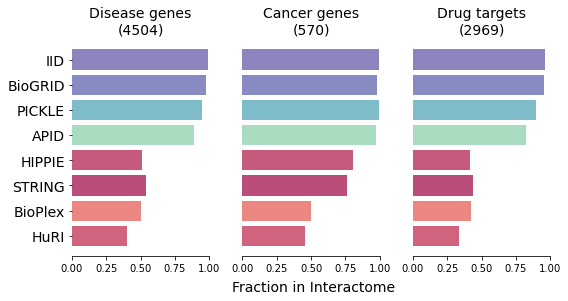

In [116]:
interactomes = [huri_prots, bioplex_prots, string_prots, hippie_prots, apid_prots, pickle_prots, biogrid_prots, iid_prots]
inames = ['HuRI', 'BioPlex', 'STRING', 'HIPPIE', 'APID', 'PICKLE', 'BioGRID', 'IID']

data = [disease_genes, cancer_genes, drug_targets]
dnames = ['Disease genes', 'Cancer genes', 'Drug targets']

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
cmap = matplotlib.cm.get_cmap('Spectral')
lens = [len(i) for i in interactomes]
rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

for data, dname, ax in zip(data, dnames, axes.flatten()):
    fractions = [len(interactome.intersection(data))/len(data) for interactome in interactomes]
    ax.set_title(f'{dname}\n({len(data)})', fontdict={'fontsize':14})
    ax.barh(range(len(interactomes)), fractions, color=cmap(rescale(lens)), alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0., 1.)
    
axes[0].set_yticks(range(len(inames)))
axes[0].set_yticklabels(inames, fontdict={'fontsize':14})
fig.text(0.55, -0.025, 'Fraction in Interactome', ha='center', fontdict={'fontsize':14})
plt.tight_layout()
plt.savefig('figures/interactome/extras_all_cmap.png', dpi=600, bbox_inches='tight')